In [45]:
# pytorch requirements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# other requirements
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import plotly.express as px

import os
import random

# custom
#from utils import set_all_seeds, load_dataset
#from config import Config

#-----------------------------                                                                                             
%matplotlib inline

In [43]:
def gpu_info():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.device_count())
gpu_info()

GeForce RTX 2080 Ti
4


In [44]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#----------utilities---------------------
# loading the dataset------------------------------------------
def load_dataset(batch_size):
    # loading the MNIST dataset
    train_set = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
    test_set = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())

    # Setting up the dataloaders
    train_dataloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
    
    return train_dataloader, test_dataloader
    
    
# setting random seeds-----------------------------------------
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers):
        super(VRNN, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        # feature extractions
        # extracting features of the input x<t> 
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # extracting features of the the latent variable z<t>
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # encoder
        self.encoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.encoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
        )
        
        self.encoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # prior distribution and its parameters
        self.prior = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.prior_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim)
        )
        
        self.prior_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.decoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid()
        )
        self.decoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Softplus()
        )
        
        # recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers)
        #self.rnn = nn.LSTM(h_dim + h_dim, h_dim, n_layers)
        
        
    def inference(self, phi_x_t, ht_minus_1):
        
        # returns the parameters of the posterior distribution
        
        encoder_input = torch.cat([phi_x_t, ht_minus_1], dim=1)
        encoder_t = self.encoder(encoder_input)
        encoder_mean_t = self.encoder_mean(encoder_t)
        encoder_var_t = self.encoder_var(encoder_t)
        
        return encoder_mean_t, encoder_var_t
    
    
    def generation_z(self, ht_minus_1):
        
        # returns the parameters of the prior distribution
        
        prior_t = self.prior(ht_minus_1)
        prior_mean_t = self.prior_mean(prior_t)
        prior_var_t = self.prior_var(prior_t)
        
        return prior_mean_t, prior_var_t
    
    
    def generation_x(self, phi_z_t, ht_minus_1):
        
        # returns the parameters of the output distribution
        
        decoder_input = torch.cat([phi_z_t, ht_minus_1], dim=1)
        decoder_t = self.decoder(decoder_input)
        decoder_mean_t = self.decoder_mean(decoder_t)
        decoder_var_t = self.decoder_var(decoder_t)
        
        return decoder_mean_t, decoder_var_t
    
    
    def recurrence(self, phi_x_t, phi_z_t, h, c=0):
        
        rnn_input = torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0)
        _, h = self.rnn(rnn_input, h) # gru
        #_, (h,c) = self.rnn(rnn_input, (h,c)) # lstm
        
        return h
    
    
    def reparameterize(self, *args):
        z_mean, z_log_var = args
        
        # sampling from a standard normal distribution
        #eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(device)
        
        # creating a random variable z drawn from a normal distribution having parameters z_mu and z_log_var
        #z = z_mean + eps*torch.exp(z_log_var/2.)

        eps = torch.FloatTensor(z_log_var.size()).normal_().to(device)
        return eps.mul(z_log_var).add_(z_mean)
        #return z

    
    
    def forward(self, x):
        
        all_encoder_mean, all_encoder_var = [], []
        all_prior_mean, all_prior_var = [], []
        all_decoder_mean, all_decoder_var = [], []
        
        timesteps = x.size(1) # timesteps = 28  (x is of shape = (batch_size, 28, 28))
        h = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        #c = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # cell state if using lstm
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[:, t, :])   # x[:, t, :] has dimensions (batch_size, 28)
        
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            #print("decoder mean vector size: ",decoder_mean_t.size())  # (batch_size, 28)
                
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1]) # gru
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            all_encoder_mean.append(encoder_mean_t)
            all_encoder_var.append(encoder_var_t)
            all_prior_mean.append(prior_mean_t)
            all_prior_var.append(prior_var_t)
            all_decoder_mean.append(decoder_mean_t)
            all_decoder_var.append(decoder_var_t)
            
        return [all_encoder_mean, all_encoder_var, all_prior_mean, all_prior_var, all_decoder_mean, all_decoder_var]
    
    
    # To sample from the prior distribution
    def sample(self, seq_len, device, get_latent_vector = False):
        
        sample = torch.zeros(seq_len, self.x_dim, device = device)
        h = torch.zeros(self.n_layers, 1, self.h_dim, device = device)
        #c = torch.zeros(self.n_layers, 1, self.h_dim, device = device) # cell state if using lstm
        
        if get_latent_vector == True:
            z = torch.zeros(seq_len, self.z_dim, device = device)
        
        for t in range(seq_len):
            
            # prior
            prior_mean_t, prior_var_t = self.generation_z(h[-1])
            
            # reparameterization
            z_t = self.reparameterize(prior_mean_t, prior_var_t)
             
            # stacking the latent vectors into a matrix 
            if get_latent_vector == True:
                z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, _ = self.generation_x(phi_z_t, h[-1])
            
            # sampling the x_t (the reconstructed output)
            #x_t = self.reparameterize(decoder_mean_t, decoder_var_t)
            
            #phi_x_t = self.phi_x(x_t)
            phi_x_t = self.phi_x(decoder_mean_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
            #print(x_t.data)
            sample[t] = decoder_mean_t.data
            #sample[t] = x_t.data
            
        if get_latent_vector == True:
            return sample, z
        return sample
    
 
    # To encode the th given input into it's latent representation
    def encode(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        z = torch.zeros(timesteps, self.z_dim, device = x.device)
        
        for t in range(timesteps):    
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h) # gru
            
        return z
    
    
    # for reconstructing the output from the given input by samping latent vector from posterior distribution
    def reconstruction_from_posterior(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        seq_len = x.size(1)
        sample_post = torch.zeros(seq_len, self.x_dim, device = x.device)
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            sample_post[t] = decoder_mean_t.data
            
        return sample_post
            

In [6]:
import torch
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
import numpy as np

In [7]:
class Losses:
    def __init__(self, device):
        self.small = torch.tensor([1e-10]).to(device)
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        kld_element =  (2 * torch.log(torch.max(std_2,self.small)) - 2 * torch.log(torch.max(std_1,self.small)) + (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /(std_2.pow(2)+1e-10) - 1)
        return 0.5 * torch.sum(kld_element)    
    
    def KLD_loss(mean_1, std_1, mean_2, std_2):
        ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
        return ret
    
    def kl_type_1(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self._kld_gauss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def kl_type_2(self, mean_1, std_1, mean_2, std_2):
        norm_dist_1 = Norm.Normal(mean_1, std_1)
        norm_dist_2 = Norm.Normal(mean_2, std_2)
        KL_loss = torch.mean(KL.kl_divergence(norm_dist_2, norm_dist_1))
        return KL_loss
    
    def kl_type_3(self, mean_1, std_1, mean_2, std_2):
        KL_loss = self.KLD_loss(mean_1, std_1, mean_2, std_2)
        return KL_loss
    
    def _nll_bernoulli(self, x, theta):
        return - torch.sum(x*torch.log(torch.max(theta, self.small)) + (1-x)*torch.log(torch.max(1-theta, self.small)))
    
    def Gaussian_nll(self, y, mu, sig):
        #nll = 0.5 * torch.sum(torch.square(y - mu) / sig**2 + 2 * torch.log(sig) + torch.log(torch.tensor(2 * np.pi)), axis=-1)
        nll = 0.5 * torch.sum(torch.square(y - mu) / (sig**2+1e-10) + 2 * torch.log(torch.max(sig,self.small)) + torch.log(torch.tensor(2 * np.pi)))
        return nll
    
    def recons_type_1(self, x, theta):
        recons_loss = _nll_bernoulli(x, theta)
        return recons_loss
    
    def recons_type_2(self, x, theta):
        recons_loss = torch.mean(F.binary_cross_entropy(theta, x, reduction = 'none'))
        return recons_loss
    
    def recons_type_3(self, y, mu, sig):
        recons_loss = Gaussian_nll(y, mu, sig)
        #recons_loss = torch.mean(recons_loss) # when axis axis=-1 in Gaussian_nll
        return recons_loss 

In [8]:
losses = Losses(device)

In [9]:
def loss_function(dist_params, x):
    
    encoder_mean, encoder_var, prior_mean, prior_var, decoder_mean, decoder_var = dist_params
    loss = 0.
    KL_loss_=0.
    recons_loss_=0.
    
    timesteps = x.size(1)
    
    for t in range(timesteps):
        
        # KL loss-------------------------------------------------------------------------------
        
        KL_loss = losses.kl_type_1(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_2(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        #KL_loss = losses.kl_type_3(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
        
        # reconstruction loss-------------------------------------------------------------------
        
        recons_loss = losses.recons_type_1(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_2(x[:, t, :], decoder_mean[t])
        #recons_loss = losses.recons_type_3(x[:, t, :], decoder_mean[t], decoder_var[t])
        
        #------------------------------------------------------------------------------------------
        loss += recons_loss + KL_loss
        KL_loss_+=KL_loss
        recons_loss_+=recons_loss
    
    return loss, KL_loss_, recons_loss_

In [10]:
# Class for Early Stopping--------------------------------------
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='saves/checkpoint3.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:

def train(model, train_dataloader, conf, epoch, device):
   
    model.train()
    size = len(train_dataloader.dataset)
    train_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        x = x.squeeze()   # x is of dimensions (batch_size, 1, 28, 28) --> after squeezing --> (batch_size, 28, 28)
        #x /= 255
        x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
        #----------------forward----------------------
        dist_params = model(x)
        loss, kl_loss, recons_loss = loss_function(dist_params, x)
        train_loss += loss.item()
        
        
        #------------backward------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ = nn.utils.clip_grad_norm_(model.parameters(), conf.clip)
        
        # ----------logging---------------
        if batch_idx % conf.print_every == 0:
            current = batch_idx*len(x)
            loss = loss.item()
            print(f"loss: {loss/conf.batch_size:>7f}  [{current:>5d}/{size:>5d}]") 
            print(f"KL_loss: {kl_loss.item()/conf.batch_size:.6f}, recons_loss: {recons_loss.item()/conf.batch_size:.6f}")
            
            # generating samples
            sample = model.sample(conf.x_dim, device)
            plt.imshow(sample.cpu().detach().numpy())
            plt.pause(1e-6)
         
        #break
    
    avg_train_loss = train_loss/size  # average training loss per epoch
    print('====> Average Train loss: {:.4f}'.format(avg_train_loss))
    
    return avg_train_loss
        

In [12]:
def test(model, test_dataloader, conf, epoch, device):
    
    model.eval()
    size = len(test_dataloader.dataset)
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_dataloader):
            x = x.to(device)
            x = x.squeeze()
            #x /= 255
            x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
            #-------forward----------------
            dist_params = model(x)
            loss,_,_ = loss_function(dist_params, x)
            
            '''
            if batch_idx % conf.print_every == 0:
                sample, z = model.sample(conf.x_dim, device)
                plt.imshow(sample.cpu().detach().numpy())
                plt.pause(1e-6)
            '''
            
            test_loss += loss.item()
    
    #--------logging-----------------
    avg_test_loss = test_loss/size  # average test loss per epoch
    print('====> Average Test loss: {:.4f}'.format(avg_test_loss))
    
    return avg_test_loss
        

In [13]:
def execute(model, train_dataoader, test_dataloader, conf, device):

    train_loss = []  # list of training losses for all epochs
    test_loss = []   # list of test losses for all epochs
    
    # instantiating the object of EarlyStopping class 
    early_stopping = EarlyStopping(patience=conf.patience, verbose=True)
    
    for ep in range(1, conf.n_epochs+1):
        
        print(f"Epoch {ep}\n-------------------------------")
        train_loss_per_epoch = train(model, train_dataloader, conf, ep, device)
        
        #break
        
        test_loss_per_epoch = test(model, test_dataloader, conf, ep, device)
        
        train_loss.append(train_loss_per_epoch)
        test_loss.append(test_loss_per_epoch)
        
        # saving model without early stopping
        """
        if ep % conf.save_every == 1:
            fn = 'saves/vrnn_state_dict_'+str(ep)+'.pt'
            torch.save(model.state_dict(), fn)
            print('Saved model to '+fn)
        """
        
        # early_stopping needs the validation/test loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss_per_epoch, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('saves/checkpoint3.pt'))
        
    print("Execution complete")
    
    return model, train_loss, test_loss

In [14]:
# configuration class for hyperparameters and other small things
class Config(object):
    
    def __init__(self):
        
        # hyperparameters
        self.x_dim = 28
        self.h_dim = 100
        self.z_dim = 16
        self.n_layers = 1
        self.n_epochs = 100
        self.clip = 10
        self.batch_size = 128
        self.learning_rate = 0.0001
        self.patience = 5
        
        # other
        self.print_every = 100
        self.save_every = 10
        self.seed = 123
        self.device_ids = [0,1,2,3]

In [15]:
def main():
    
    # set the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    # instantiate the config class and set up the seeds    
    conf = Config()
    set_all_seeds(123)

    # set up the data loaders
    train_dataloader, test_dataloader = load_dataset(conf.batch_size)

    # instantiate the model and set up the optimizer    
    model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
    #model= nn.DataParallel(model, device_ids = conf.device_ids)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = conf.learning_rate)

    # run model
    model, train_loss, test_loss = execute(model, train_dataloader, test_dataloader, conf, device)
    return model, train_loss, test_loss

In [ ]:
model, train_loss, test_loss = main()

In [35]:
torch.cuda.memory_allocated()

49804288

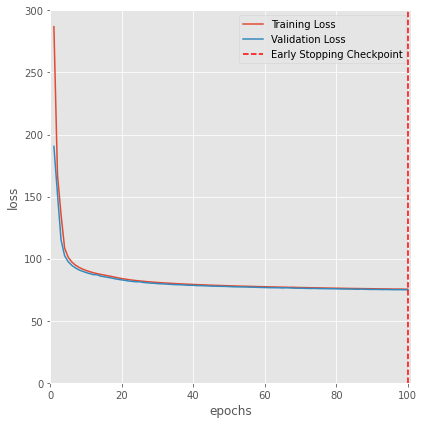

In [37]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(6,6))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 300) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [16]:
# set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

In [17]:
state_dict = torch.load('saves/checkpoint2.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
model = model.to(device)
model.load_state_dict(state_dict)


<All keys matched successfully>

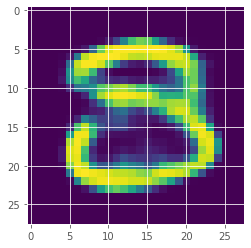

In [42]:
# generating samples from prior distribution
sample = model.sample(28, device)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

In [23]:
train_dataloader, test_dataloader = load_dataset(conf.batch_size)

/home2/jhansi.mallela/anaconda3/envs/deepspace/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [117]:
# for getting the desired length subset of the dataset
#test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, 50))

In [19]:
def get_data(data_loader):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    #print(images.size())  # ---> torch.Size([128, 1, 28, 28]) # batch_size number of images
    #print(images[0].size()) # ---> torch.Size([1, 28, 28])     # images[0] is the image at index 0 in the given batch
    #print(images[0].squeeze(0).size())  # ---> torch.Size([28, 28])
    return images, labels

In [ ]:
images, labels = get_data(train_dataloader)
#images, labels = get_data(test_dataloader)

In [25]:
index = 10  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  5


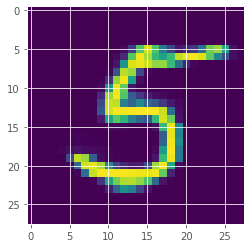

In [26]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

In [28]:
#images, labels = get_data(train_dataloader)
images, labels = get_data(test_dataloader)

In [35]:
index = 26  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  6


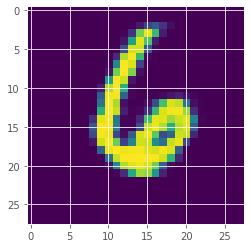

In [36]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

### Latent Space Analysis

In [24]:
def get_latent_var(data):
    
    # img has dimensions (1,28,28) 
    img = data[0].squeeze().to(device)   # --> has dimensions (28,28)
    label = data[1]
    
    #print(img.size())     # --> has dimensions (28, 28)
    #print(img.unsqueeze(0).size())  # --> dimensions = (1,28,28)
    #print(img[i].size())   # --> has dimensions (28,)
    #print(img[i].unsqueeze(0).size())  # --> has dimensions (1,28)

    # encode img
    model.eval()
    with torch.no_grad():
        z = model.encode(img)
        
    z = z.cpu().detach().numpy()  # has shape --> (28, 16)
    #print(z[-1])
        
    return z

In [25]:
subset_len = 500
test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, subset_len))
train_set = torch.utils.data.Subset(train_dataloader.dataset, range(0, subset_len))

In [26]:
data_set = train_set
#data_set = test_set

In [27]:
def get_z_array(data_set):
    z_array = []
    labels = []
    
    for data in data_set:
        z = get_latent_var(data)
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        
        #z = np.sum(z, axis=0)
        #z = np.expand_dims(z, axis=0)
        
        z_array.append(z)
        labels.append(data[1])
        
    return z_array, labels

In [122]:
z_array, labels = get_z_array(data_set)

In [123]:
cnt=0
for i in labels:
    if i==5:
        cnt+=1

In [124]:
cnt

39

In [37]:
def plot_latent_vars(z_array, labels, digit = None):
    
    if digit != None:
        z_arr = z_array
        z_array = []
        for idx in range(len(labels)):
            if labels[idx] == digit:
                z_array.append(z_arr[idx])
    n_row = 3
    n_col = 4
    fig, axes = plt.subplots(n_row, n_col, figsize = (30,30))
    idx = 0
    for i in range(n_row):
        for j in range(n_col):
            axes[i,j].imshow(z_array[idx])
            if digit == None:
                axes[i,j].set_title(f'Digit = {labels[idx]}')
            else:
                axes[i,j].set_title(f'Digit = {digit}')
            idx+=1
    plt.show()

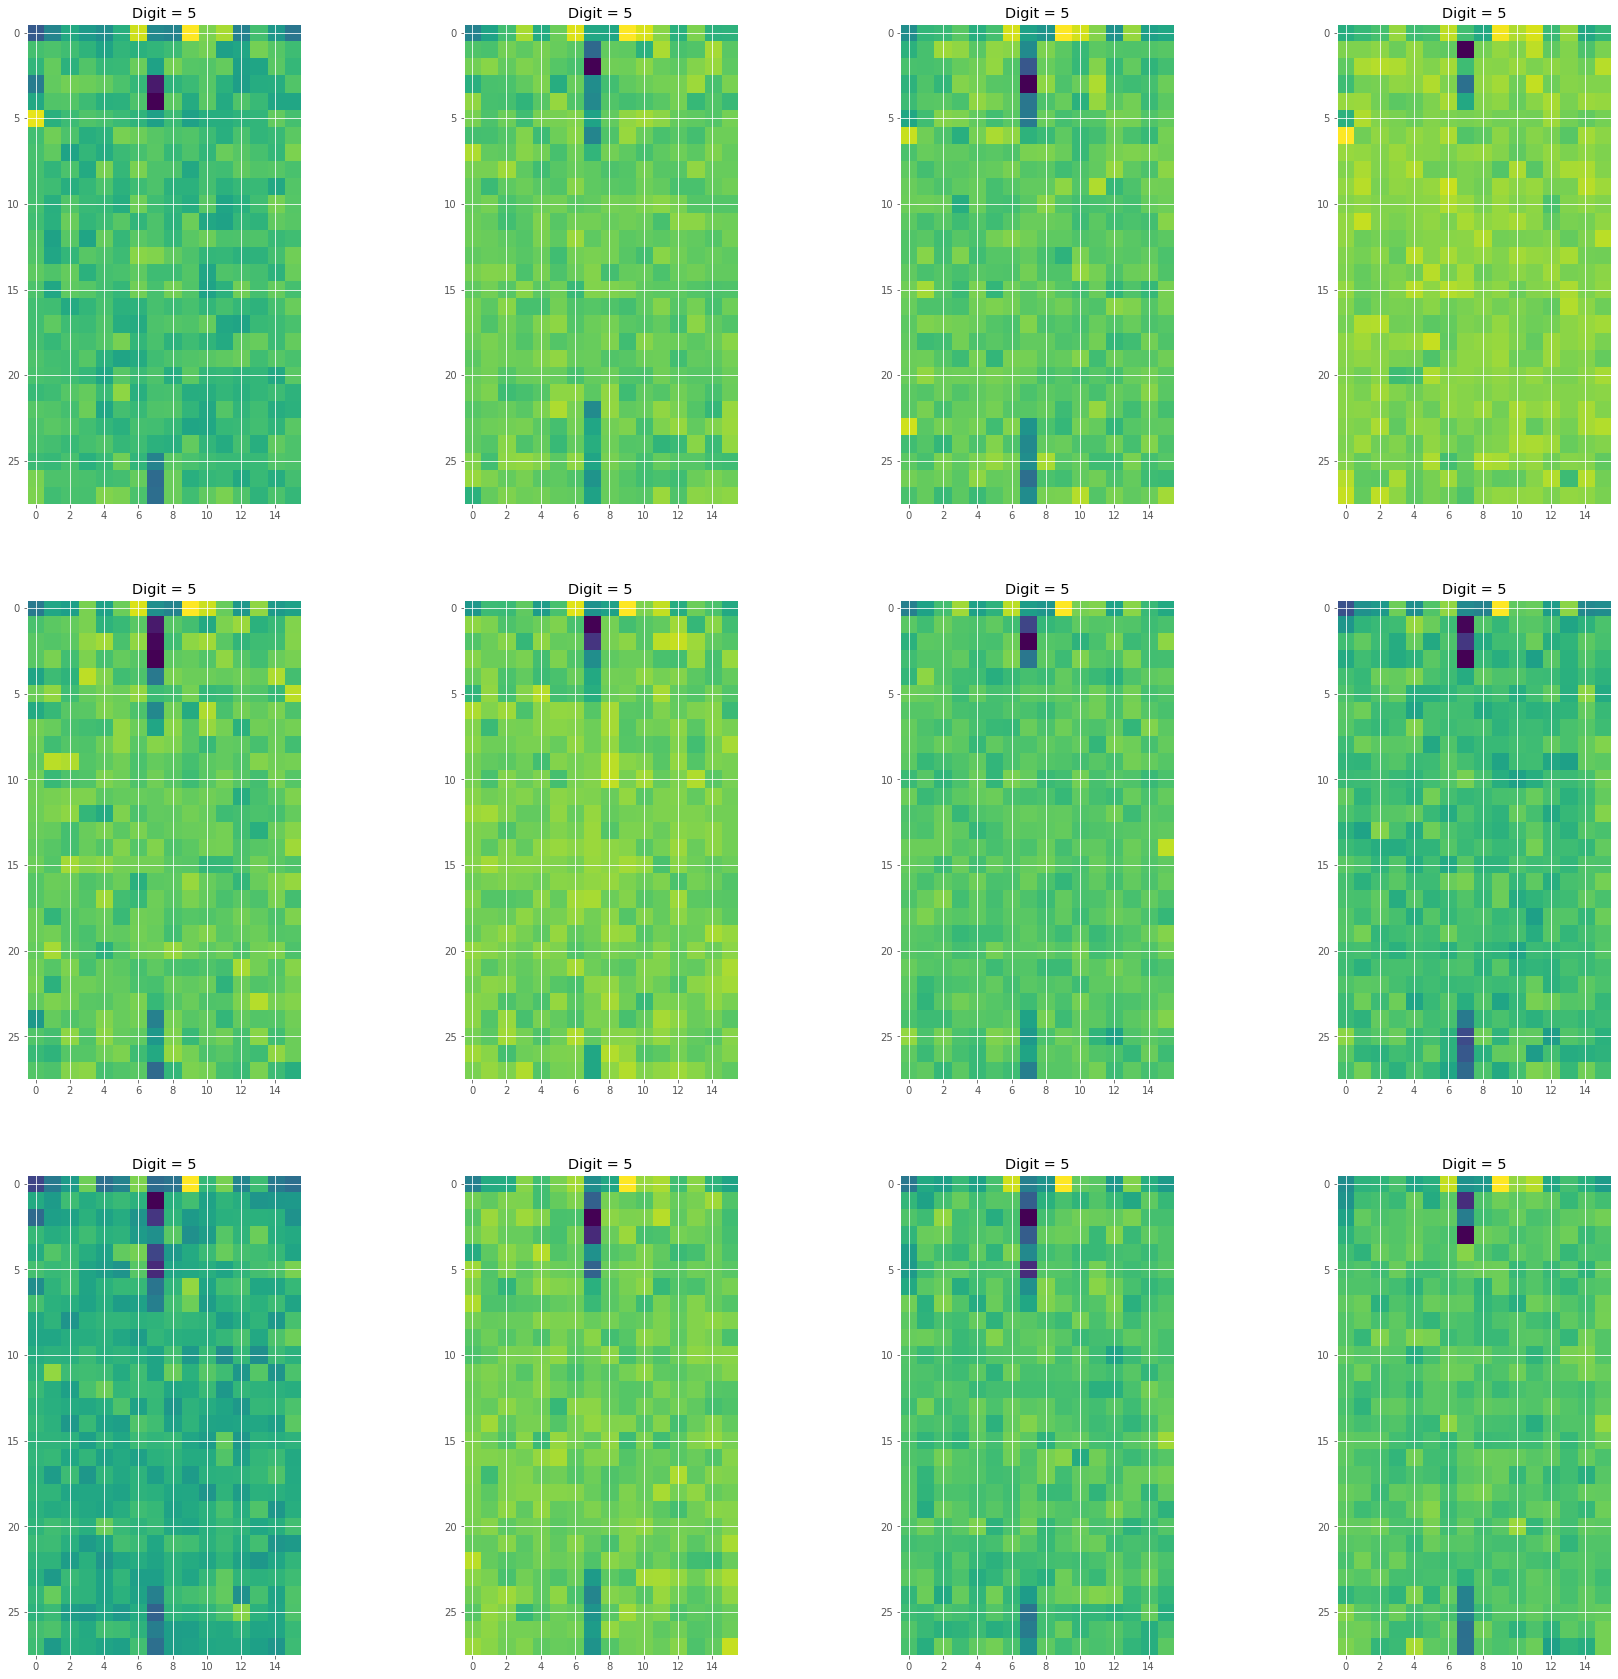

In [38]:
digit = 5
plot_latent_vars(z_array, labels, digit)

In [207]:
def plot_latent_vars(z_array, labels, digit = None):
    
    if digit != None:
        z_arr = z_array
        z_array = []
        for idx in range(len(labels)):
            if labels[idx] == digit:
                z_array.append(z_arr[idx])
    n_row = 3
    n_col = 5
    fig, axes = plt.subplots(n_row, n_col, figsize = (30,30))
    idx = 0
    for i in range(n_row):
        for j in range(n_col):
            axes[i,j].imshow(z_array[idx])
            if digit == None:
                axes[i,j].set_title(f'Digit = {labels[idx]}')
            else:
                axes[i,j].set_title(f'Digit = {digit}')
            idx+=1
    plt.show()

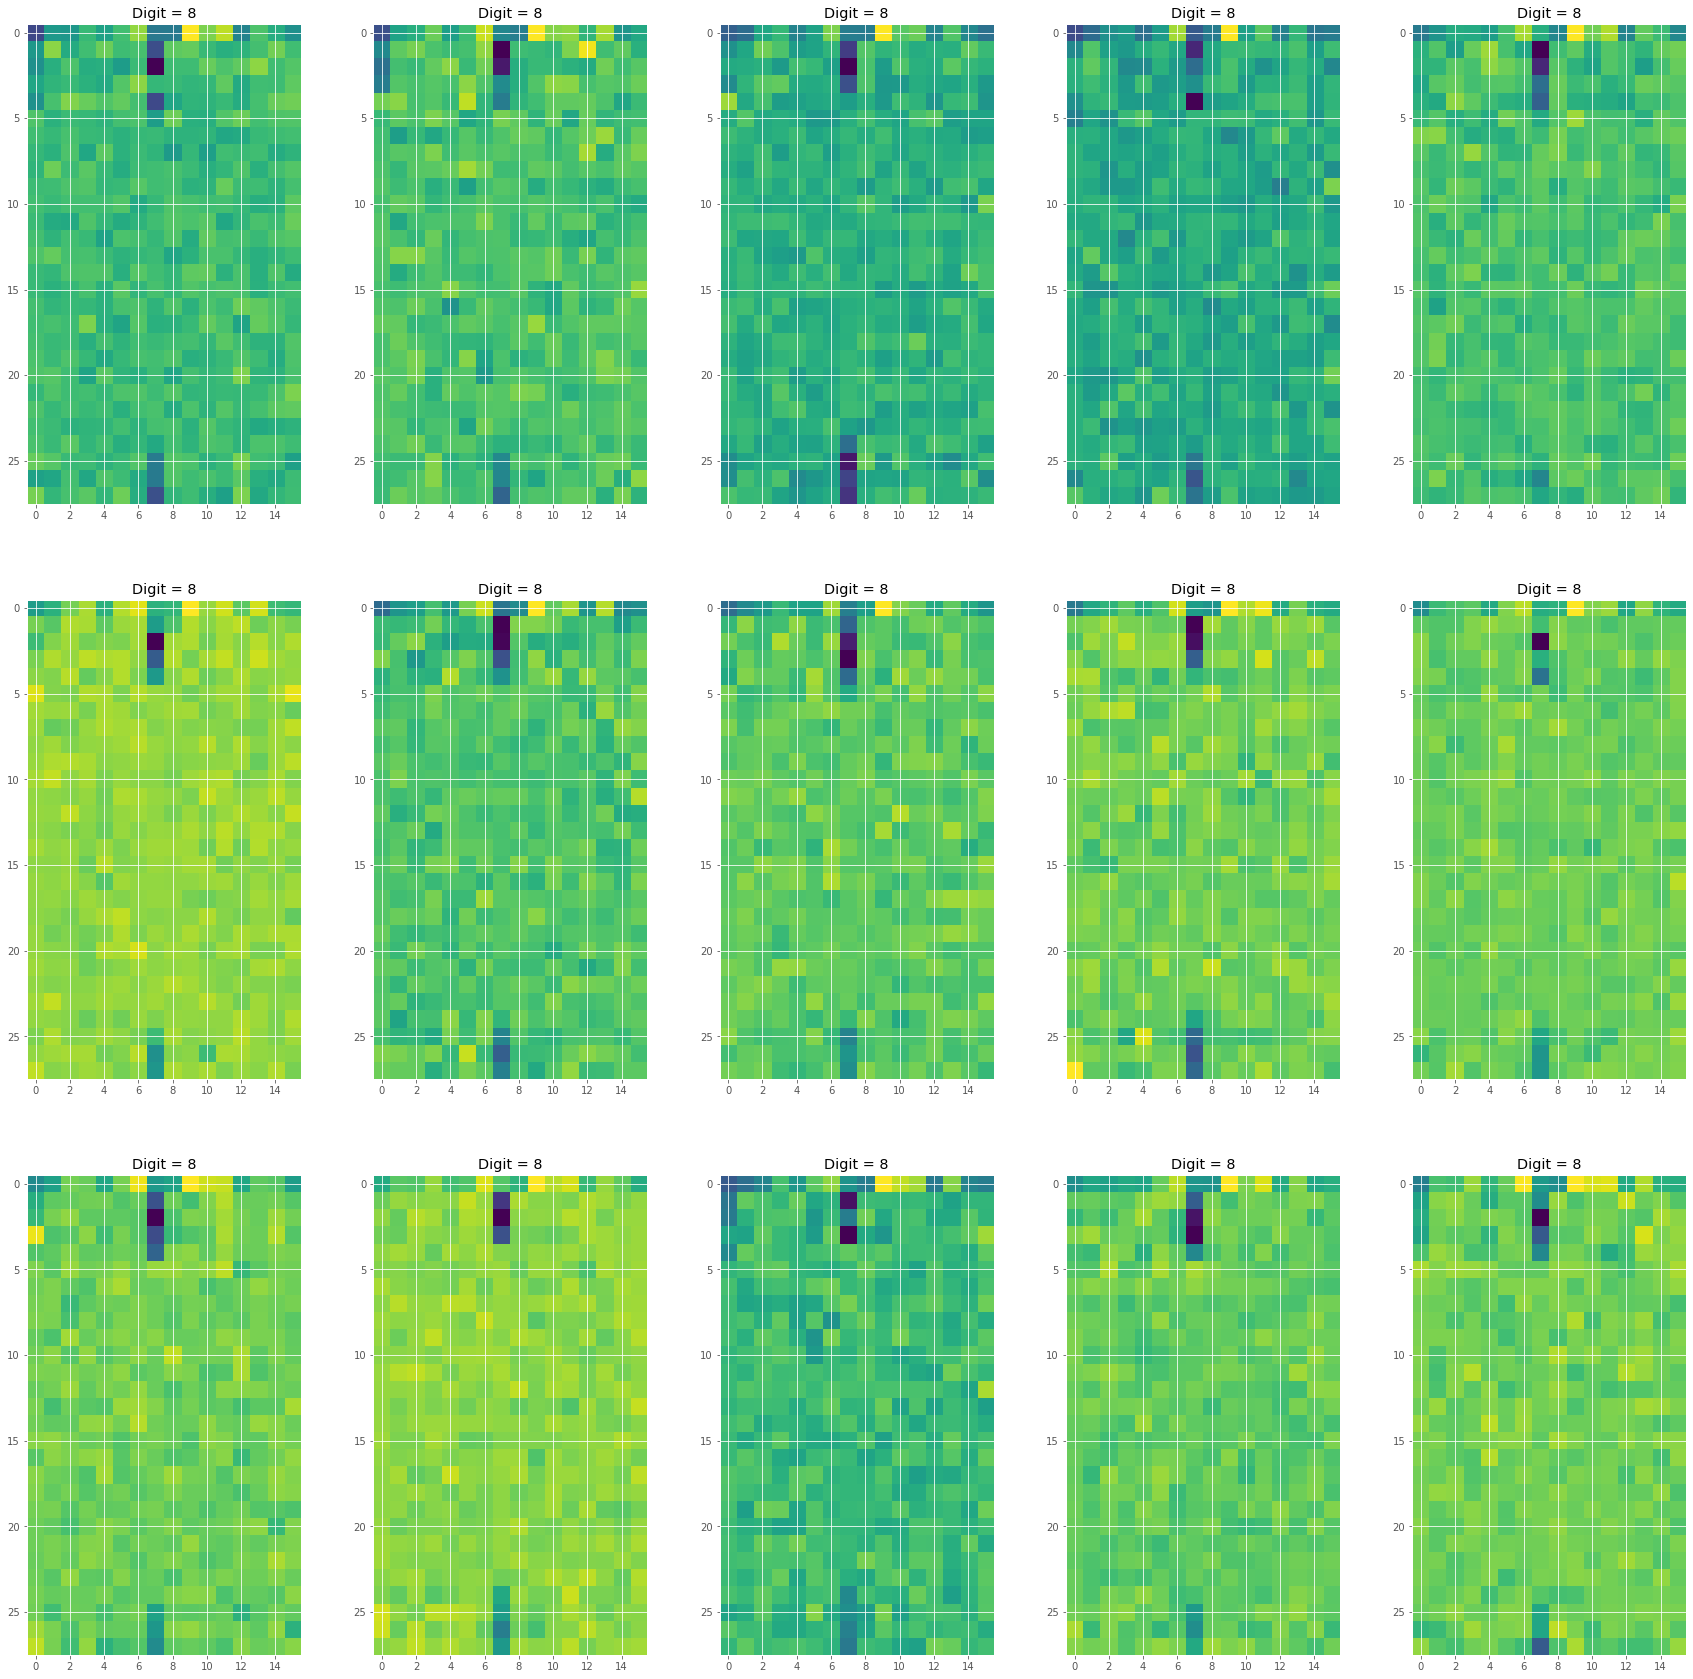

In [208]:
digit = 8
plot_latent_vars(z_array, labels, digit)

In [28]:
def get_z_array2(data_set):
    z_array = []
    labels = []
    
    for data in data_set:
        z = get_latent_var(data)
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        
        z = np.sum(z, axis=0)
        z = np.expand_dims(z, axis=0)
        
        z_array.append(z)
        labels.append(data[1])
        
    return z_array, labels

In [29]:
z_array, labels = get_z_array2(data_set)

In [175]:
z_array[0].shape

(1, 16)

In [140]:
len(z_array)

500

In [141]:
z_array = np.array(z_array)

In [142]:
z_array.shape

(500, 1, 16)

In [143]:
z_array = z_array.squeeze(1)

In [144]:
z_array.shape

(500, 16)

In [145]:
_labels = [str(i) for i in labels]

In [30]:
def plot_tsne(z_array, _labels):
    
    z_array = np.array(z_array)
    z_array = z_array.squeeze(1)
    _labels = [str(i) for i in labels]
    
    tsne = TSNE(n_components=2)
    #tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    tsne_results = tsne.fit_transform(z_array)

    fig = px.scatter(tsne_results, x=0, y=1, color=_labels,labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
    fig.show()

In [31]:
plot_tsne(z_array, labels)

In [32]:
def get_sample_dataset(subset_len):
    test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, subset_len))
    train_set = torch.utils.data.Subset(train_dataloader.dataset, range(0, subset_len))
    return test_set, train_set

In [33]:
train_set, test_set = get_sample_dataset(1000)

In [34]:
z_array, labels = get_z_array2(train_set)

In [35]:
plot_tsne(z_array, labels)

In [36]:
train_set, test_set = get_sample_dataset(5000)

In [37]:
z_array, labels = get_z_array2(train_set)

In [38]:
plot_tsne(z_array, labels)

In [39]:
train_set, test_set = get_sample_dataset(3000)

In [40]:
z_array, labels = get_z_array2(test_set)

In [41]:
plot_tsne(z_array, labels)

In [42]:
def get_z_array3(data_set):
    z_array = []
    labels = []
    
    for data in data_set:
        z = get_latent_var(data)
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        
        z = np.sum(z, axis=0)
        z = z/28
        z = np.expand_dims(z, axis=0)
        
        z_array.append(z)
        labels.append(data[1])
        
    return z_array, labels

In [46]:
train_set, test_set = get_sample_dataset(1000)

In [47]:
z_array, labels = get_z_array3(test_set)

In [48]:
plot_tsne(z_array, labels)